# Customer churn (Kaggle). Sklearn solution

This notebook contains solution of Customer churn competition with use of `sklearn` library.

The solution includes:
- Data preparation
- Custom FrequencyEncoder
- Custom Transformer (with pipeline containing different data processing and encoding strategies: `OneHot`, `Ordinal`, `Frequency`)
- Different base algorithms comparison (`RidgeClassiifer`, `RandomForestClassifier`, `GradientBoostingClassifier`, `LGBMClassifier`)
- Final pipeline, containing data transformer, feature selectors, random oversampler and gradient boosting classiifer
- Grid search for the best parameters
- Final evaluation score of `0.707` (better than the other `35%` of participants)

## Task description

https://www.kaggle.com/c/telecom-clients-prediction2/overview/description

The task is to build a model that predicts churn-prone customers. As an answer, it is required to give a probalistic estimate of belonging to class 1 ('1' - churn, '-1' - not churn).

Data contains missing values and categorical variables. The data is private and is provided without description. The dataset consists of 230 variables, of which the first 190 are numeric and the remaining 40 are categorical.

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import (train_test_split, learning_curve, KFold, StratifiedKFold,
                                     cross_val_score, GridSearchCV, RandomizedSearchCV)

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

import imblearn
from imblearn.pipeline import make_pipeline

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer

from sklearn.base import TransformerMixin, BaseEstimator

import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel, f_classif, SelectKBest, VarianceThreshold

import warnings
warnings.filterwarnings('default')

In [2]:
import dill

In [6]:
dill.load_session('churn_kaggle_backup.db')

In [5]:
# Cчитаем данные из файла
raw_data = pd.read_csv('orange_small_churn_train_data.csv')

In [6]:
raw_data

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1.0
1,1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1.0
2,2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1.0
3,3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1.0
4,4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18294,18294,NaN,NaN,NaN,NaN,NaN,462.0,0.0,NaN,NaN,...,mErwEWL,LM8l689qOp,NaN,NaN,uWr3,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0
18295,18295,NaN,NaN,NaN,NaN,NaN,1603.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,kG3k,uWr3,ZI9m,ib5G6X1eUxUn6,am7c,NaN,1.0
18296,18296,NaN,NaN,NaN,NaN,NaN,1239.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,Qcbd,ZI9m,55YFVY9,am7c,NaN,-1.0
18297,18297,NaN,NaN,NaN,NaN,NaN,210.0,0.0,NaN,NaN,...,wg_DmEs,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0


In [7]:
data = raw_data.copy()
data.labels[data.labels.isna()]

18298   NaN
Name: labels, dtype: float64

In [8]:
data.drop(index=[18298], inplace=True)

In [9]:
data.labels.value_counts()

-1.0    16921
 1.0     1377
Name: labels, dtype: int64

In [10]:
y_data = data.labels.values

In [11]:
y_data

array([-1., -1., -1., ...,  1., -1., -1.])

In [12]:
data.drop(columns=['ID', 'labels'], inplace=True)

In [13]:
columns_to_drop = []
real_feats = []

for column in data.columns[:190]:
    uniq_counts = len(data.loc[:, column].value_counts())
    
    if uniq_counts == 0:
        columns_to_drop.append(column)
    else:
        real_feats.append(column)

In [14]:
bin_feats = []
cat_feats = []

for column in data.columns[190:]:
    
    uniq_counts = len(data.loc[:, column].value_counts())
    
    # Если есть Nan, то будем добавлять как доп. категорию
    uniq_counts += np.any(data.loc[:, column].isna())
    
    if  uniq_counts <= 1:
        columns_to_drop.append(column)
        
    elif uniq_counts == 2:
        bin_feats.append(column)
    
    else:
        cat_feats.append(column)

In [15]:
columns_to_drop

['Var8',
 'Var15',
 'Var20',
 'Var31',
 'Var32',
 'Var39',
 'Var42',
 'Var48',
 'Var52',
 'Var55',
 'Var79',
 'Var141',
 'Var167',
 'Var169',
 'Var175',
 'Var185',
 'Var209',
 'Var230']

In [12]:
def binary_processing(bdata):
    bdata_ = bdata.copy()
    
    for bin_feat in bdata.columns:
        
        bin_isna = bdata_[bin_feat].isna() 
        
        if np.any(bin_isna):
            # NaN маркируем 0
            pos0 = bin_isna
        else:    
            # менее частый признак маркируем 0
            val_cnts = bdata_[bin_feat].value_counts()
            label0 = val_cnts.index[val_cnts.argmin()]
            pos0 = bdata_[bin_feat] == label0
        
        bdata_.loc[pos0, bin_feat] = 0
        bdata_.loc[~pos0, bin_feat] = 1
    
    return bdata_.astype(bool)

In [13]:
def get_indices(X, cols_to_get):
    return [(col in cols_to_get) for col in X.columns]

In [14]:
inds_real = get_indices(data, real_feats)
inds_bin = get_indices(data, bin_feats)
inds_cat = get_indices(data, cat_feats)

In [15]:
feat_inds = [inds_real, inds_bin, inds_cat]

In [16]:
from sklearn.base import TransformerMixin 
from collections import Counter

class FrequencyEncoder(TransformerMixin):
    def __init__(self, *, normalization=True):
        self.normalization = normalization
    
    def fit(self, X, y=None):
        cnts = [Counter(X.iloc[:, j]) for j in range(X.shape[1])]
        self.cnts = cnts
        return self
    
    def transform(self, X):        
        X_ = X.copy()
        
        for j in range(X_.shape[1]):
            uniq_vals = self.cnts[j].keys()            
            idx_isnew = [x not in uniq_vals
                         for x in X_.iloc[:, j]]
            X_.iloc[idx_isnew, j] = sum(idx_isnew)
        
        for j in range(X_.shape[1]):
            X_.iloc[:, j].replace(self.cnts[j], inplace=True)
        
        if self.normalization:
            X_ = X_ / len(X_)
        
        return X_

In [17]:
# Пропуски real заполняем 0 если rfill = 0, или средним по столбцу, если False
# Категориальные значения обрабатываем стратегиями OneHotEncoder/LabelEncoder/

class Transformer(TransformerMixin, BaseEstimator):
    def __init__(self, inds_real, inds_bin, inds_cat, *, rfill=0, catstrategy='OneHot'):
        self.inds_real = inds_real
        self.inds_bin = inds_bin
        self.inds_cat = inds_cat
    
        if rfill == 0:
            self.rfill = 0
        elif rfill == 'mean':
            self.rfill = 'mean'
            
        self.catstrategy = catstrategy
        
        self.encoders_ = {'OneHot': OneHotEncoder(handle_unknown='ignore'),
                          'Ordinal': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
                          'Frequency': FrequencyEncoder()}
    
    def fit(self, X, y=None):
        transformer = Pipeline(steps = [
             ('feature_processing', FeatureUnion(transformer_list=[
                 ('real_val_processing', Pipeline(steps = [
                      ('selecting', FunctionTransformer(lambda data: data.iloc[:, self.inds_real])),
                      ('fillna', FunctionTransformer(lambda data: data.fillna(
                                                                              0 if self.rfill==0 else data.mean()
                                                                             ))),
                      ('scaling', StandardScaler())
                 ])),

                  ('bin_val_processing', Pipeline(steps = [
                      ('selecting', FunctionTransformer(lambda data: data.iloc[:, self.inds_bin])),
                      ('encoding', FunctionTransformer(binary_processing))
                  ])),

                  ('cat_val_processing', Pipeline(steps = [
                      ('selecting', FunctionTransformer(lambda data: data.iloc[:, self.inds_cat])),
                      ('fillna', FunctionTransformer(lambda data: data.fillna('NaN'))),
                      ('encoding', self.encoders_[self.catstrategy])
                  ]))
             ]))
        ])
        
        transformer.fit(X)
        self.transformer = transformer
        
        return self
    
    def transform(self, X):
        return self.transformer.transform(X)

In [18]:
Transformer(*feat_inds).fit_transform(X_)

<14638x35345 sparse matrix of type '<class 'numpy.float64'>'
	with 3013629 stored elements in Compressed Sparse Row format>

In [ ]:
# oh_feats = A.named_steps['feature_processing'].transformer_list[2][1].named_steps['encoding'].get_feature_names()

In [ ]:
# # binary_procesing tests

# test_a = pd.DataFrame([['a'],['b'], ['a'], ['a'], ['b']])
# test_b = pd.DataFrame([['a', 31], ['b', 11], ['a', 11], ['a', 11], ['b', 11]], columns=['c1', 'c2'])
# test_c = pd.DataFrame([['a', np.nan], ['b', 31], ['a', np.nan], ['a', np.nan], ['b', np.nan]],
#                       columns=['c1', 'c2'])

In [ ]:
# # real_procesing tests

# test_a = pd.DataFrame([[1],[np.nan], [2], [3], [np.nan]])
# test_b = pd.DataFrame([[1, 1], [2, 2], [3, 2], [4, 1], [5, np.nan]], columns=['c1', 'c2'])
# test_c = pd.DataFrame([['a', np.nan], ['b', 31], ['a', np.nan], ['a', np.nan], ['b', np.nan]],
#                       columns=['c1', 'c2'])

In [19]:
churnInd = np.argwhere(y_data == 1)
notchurnInd = np.argwhere(y_data == -1)

In [20]:
print('Доли неоттока, оттока:')
len(y_data[notchurnInd])/len(y_data), len(y_data[churnInd])/len(y_data)

Доли неоттока, оттока:


(0.9247458738659963, 0.07525412613400372)

In [23]:
# Параметры обучения:
# test_size, rfill_0, oversamling(sampling_strategy)
# 

In [24]:
data

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18293,NaN,NaN,NaN,NaN,NaN,3892.0,0.0,NaN,NaN,NaN,...,oslk,LsdaF5M,NaN,NaN,NaN,Xa3G,RAYp,F2FyR07IdsN7I,NaN,NaN
18294,NaN,NaN,NaN,NaN,NaN,462.0,0.0,NaN,NaN,NaN,...,oslk,mErwEWL,LM8l689qOp,NaN,NaN,uWr3,RAYp,F2FyR07IdsN7I,NaN,NaN
18295,NaN,NaN,NaN,NaN,NaN,1603.0,7.0,NaN,NaN,NaN,...,zCkv,catzS2D,LM8l689qOp,NaN,kG3k,uWr3,ZI9m,ib5G6X1eUxUn6,am7c,NaN
18296,NaN,NaN,NaN,NaN,NaN,1239.0,7.0,NaN,NaN,NaN,...,oslk,catzS2D,LM8l689qOp,NaN,ELof,Qcbd,ZI9m,55YFVY9,am7c,NaN


# Hold out dataset

In [25]:
test_size=0.2

X_, X_hold, y_, y_hold = train_test_split(data, y_data, stratify=None, random_state=0,
                                                    shuffle=True, test_size=test_size)

transformer = Transformer(*feat_inds, rfill=0, catstrategy='OneHot')
transformer.fit(X_)

Transformer(inds_bin=[False, False, False, False, False, False, False, False,
                      False, False, False, False, False, False, False, False,
                      False, False, False, False, False, False, False, False,
                      False, False, False, False, False, False, ...],
            inds_cat=[False, False, False, False, False, False, False, False,
                      False, False, False, False, False, False, False, False,
                      False, False, False, False, False, False, False, False,
                      False, False, False, False, False, False, ...],
            inds_real=[True, True, True, True, True, True, True, False, True,
                       True, True, True, True, True, False, True, True, True,
                       True, False, True, True, True, True, True, True, True,
                       True, True, True, ...])

In [26]:
X = transformer.transform(X_)
y = y_

# Learning Curve

Оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и возможно, что начиная с некоторого момента рост размера обучающей выборки перестанет влиять на качество модели. Построим кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Проверим для **LGBMClassifier**, **RidgeClassifier**, **GradientBoostingClassifier** и **RandomForestClassifier**. Для замера будем использовать метрику ***ROC AUC***

In [20]:
# LGBMClassifier

In [ ]:
%%time

lgbmc = LGBMClassifier()

cv = KFold(5)

(train_sizes,
 train_scores_lgbmc,
 test_scores_lgbmc) = learning_curve(lgbmc, X, y, cv=cv, 
                                     n_jobs=-1, scoring='roc_auc')

In [21]:
def plot_learning_curve(train_sizes, train_scores, test_scores, algo_name):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn')

    fig, ax = plt.subplots()

    ax.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
    ax.plot(train_sizes, test_scores.mean(axis=1), label='Testing score')

    ax.legend()
    ax.set_title(f'Learning curve, {algo_name}')

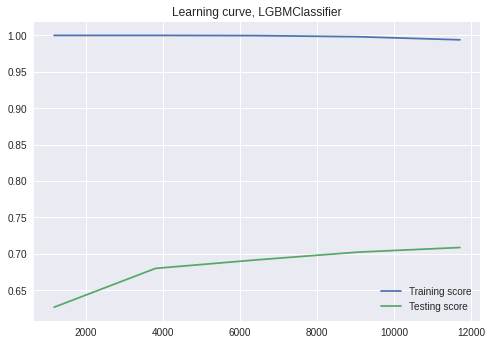

In [15]:
plot_learning_curve(train_sizes, train_scores_lgbmc,
                    test_scores_lgbmc, 'LGBMClassifier')

In [16]:
print(np.round(train_scores_lgbmc.mean(axis=1), 4))
print(np.round(test_scores_lgbmc.mean(axis=1), 4))
print(train_sizes)

[1.     1.     0.9997 0.9982 0.9939]
[0.6265 0.6799 0.6916 0.7023 0.7086]
[ 1171  3805  6440  9075 11710]


In [17]:
# RidgeClassifier

In [ ]:
%%time

ridge = RidgeClassifier()

(_,
 train_scores_ridge,
 test_scores_ridge) = learning_curve(ridge, X, y,
                                     n_jobs=-1, cv=5, scoring='roc_auc')

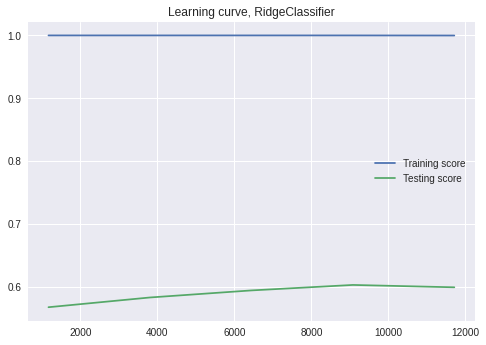

In [18]:
plot_learning_curve(train_sizes, train_scores_ridge,
                    test_scores_ridge, 'RidgeClassifier')

In [ ]:
print(np.round(train_scores_ridge.mean(axis=1), 4))
print(np.round(test_scores_ridge.mean(axis=1), 4))
print(train_sizes)

In [19]:
# GradientBoostingClassifier

In [ ]:
%%time

gbst_clsfr = GradientBoostingClassifier()

(_,
 train_scores_gbst,
 test_scores_gbst) = learning_curve(gbst_clsfr, X, y,
                                    n_jobs=-1, cv=5, scoring='roc_auc')

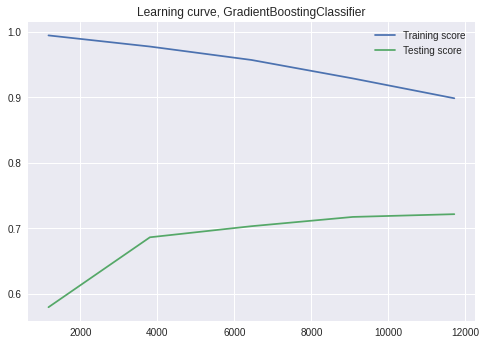

In [20]:
plot_learning_curve(train_sizes, train_scores_gbst,
                    test_scores_gbst, 'GradientBoostingClassifier')

In [21]:
print(np.round(train_scores_gbst.mean(axis=1), 4))
print(np.round(test_scores_gbst.mean(axis=1), 4))
print(train_sizes)

[0.9946 0.9776 0.9571 0.9289 0.8985]
[0.5793 0.6861 0.7031 0.7172 0.7214]
[ 1171  3805  6440  9075 11710]


In [22]:
# RandomForestClassifier

In [ ]:
%%time

rfrst_clsfr = RandomForestClassifier()

(_,
 train_scores_rfrst,
 test_scores_rfrst) = learning_curve(rfrst_clsfr, X, y,
                                     n_jobs=-1, cv=5, scoring='roc_auc')

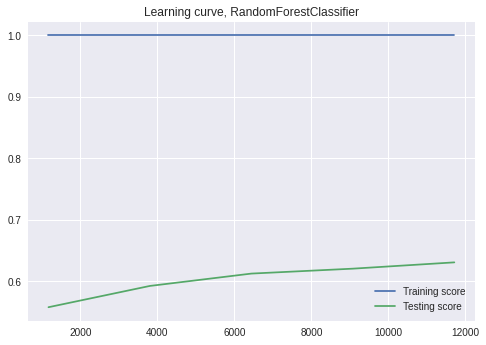

In [23]:
plot_learning_curve(train_sizes, train_scores_rfrst,
                    test_scores_rfrst, 'RandomForestClassifier')

In [24]:
print(np.round(train_scores_rfrst.mean(axis=1), 4))
print(np.round(test_scores_rfrst.mean(axis=1), 4))
print(train_sizes)

[1. 1. 1. 1. 1.]
[0.5576 0.5923 0.6123 0.6204 0.6306]
[ 1171  3805  6440  9075 11710]


Вывод:
Все алгоритмы достаточно сильно переобучились под тестовую выборку, лучше всего себя показал ***GradientBoostingClassifier***. Менять размер выборки X не будем

# Weights variation

In [27]:
from collections import Counter
ch_sizes = Counter(y_)
ch_sizes

Counter({-1.0: 13522, 1.0: 1116})

Результатов оттока примерно в 12 раз больше, поэтому будем пытаться варьировать отношение весов от 1 до 12 с шагом 1. Проверять будем на кросс-валидации по 5 фолдам

In [27]:
churn_weights = list(range(1, 13))

In [28]:
def plot_weights_variations(churn_weights, results, algo_name):
    fig, ax = plt.subplots()

    ax.plot(churn_weights, results)
    ax.set_title(f'Weights variation curve, {algo_name}')
    ax.set_xlabel('weight')

In [29]:
# LGBMClassifier

In [ ]:
%%time

lgbmc_wght_res = []

for w in churn_weights:
    lgbmc_wght = LGBMClassifier(class_weight={1:w, -1:1})
    cv_score = cross_val_score(lgbmc_wght, X, y,
                               n_jobs=-1, scoring='roc_auc', cv=5)
    lgbmc_wght_res.append(cv_score.mean())

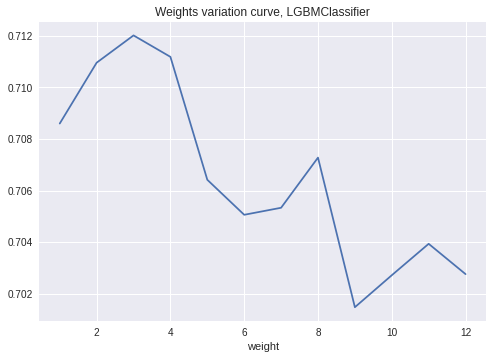

In [30]:
plot_weights_variations(churn_weights, lgbmc_wght_res, 'LGBMClassifier')

In [ ]:
np.round(lgbmc_wght_res, 4)

In [31]:
# RidgeClassifier

In [ ]:
%%time

ridge_wght_res = []

for w in churn_weights:
    ridge_wght = RidgeClassifier(class_weight={1:w, -1:1})
    cv_score = cross_val_score(ridge_wght, X, y,
                               n_jobs=-1, scoring='roc_auc', cv=5)
    ridge_wght_res.append(cv_score.mean())

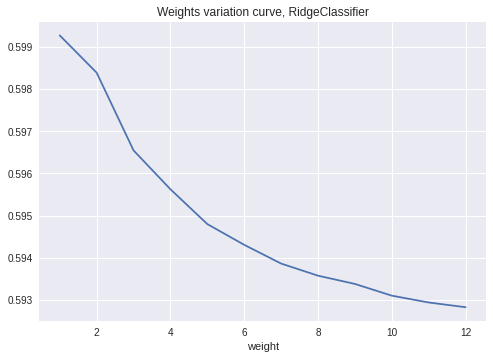

In [32]:
plot_weights_variations(churn_weights, ridge_wght_res, 'RidgeClassifier')

In [33]:
np.round(ridge_wght_res, 4)

array([0.5993, 0.5984, 0.5965, 0.5956, 0.5948, 0.5943, 0.5939, 0.5936,
       0.5934, 0.5931, 0.5929, 0.5928])

In [34]:
# RandomForestClassifier

In [ ]:
%%time

rfrst_wght_res = []

for w in churn_weights:
    rfrst_wght = RandomForestClassifier(class_weight={1:w, -1:1})
    cv_score = cross_val_score(rfrst_wght, X, y,
                               n_jobs=-1, scoring='roc_auc', cv=5)
    rfrst_wght_res.append(cv_score.mean())

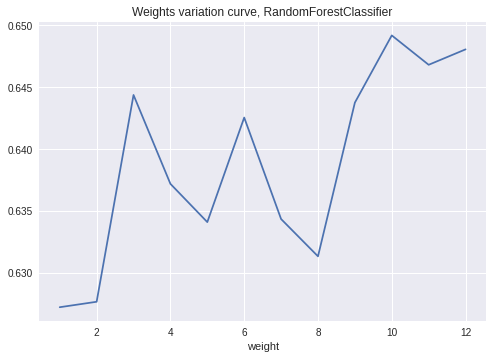

In [35]:
plot_weights_variations(churn_weights, rfrst_wght_res, 'RandomForestClassifier')

In [36]:
np.round(rfrst_wght_res, 4)

array([0.6272, 0.6277, 0.6444, 0.6372, 0.6341, 0.6426, 0.6343, 0.6313,
       0.6438, 0.6492, 0.6468, 0.6481])

In [37]:
# GradientBoostingClassifier

In [ ]:
%%time

gbst_wght_res = []

for w in churn_weights:
    strategy = {1.:w*ch_sizes[1.]}
    gbst_estimator = make_pipeline(RandomOverSampler(random_state=0, sampling_strategy=strategy),
                                   GradientBoostingClassifier())
    
    cv_score = cross_val_score(gbst_estimator, X, y,
                               n_jobs=-1, scoring='roc_auc', cv=5)
    gbst_wght_res.append(cv_score.mean())

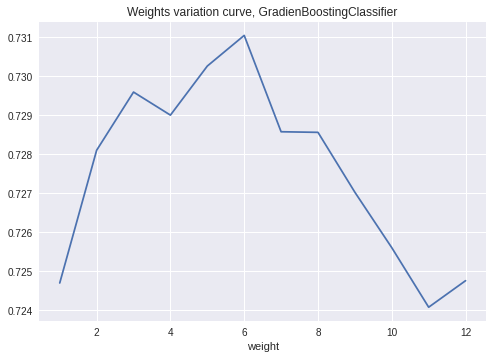

In [38]:
plot_weights_variations(churn_weights, gbst_wght_res, 'GradienBoostingClassifier')

In [39]:
np.round(gbst_wght_res, 4)

array([0.7247, 0.7281, 0.7296, 0.729 , 0.7303, 0.731 , 0.7286, 0.7286,
       0.727 , 0.7256, 0.7241, 0.7248])

# Undersampling

In [40]:
ratios = np.arange(0.1, 1.1, 0.1) # N_churn / N_notchurn
ratios

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [41]:
def cv_roc_undrsmpl(estimator, X, y, ratios):
    results = []
    
    for ratio in ratios:
        undersampler = RandomUnderSampler(random_state=0, sampling_strategy=ratio)
        X_us, y_us = undersampler.fit_resample(X, y)
        
        cv_score = cross_val_score(estimator, X_us, y_us,
                                   n_jobs=-1, scoring='roc_auc', cv=5)
        results.append(cv_score)
    
    return results

In [42]:
def plot_us_res(ratios, results, algo_name):
    fig, ax = plt.subplots()
    
    ax.plot(ratios, np.mean(results, axis=1))
    ax.set_title(f'Undersampling curve, {algo_name}')
    ax.set_xlabel('ratio  N_churn / N_notchurn')

In [43]:
# LGBMClassifier

In [50]:
%%time
lgbmc_us_res = cv_roc_undrsmpl(LGBMClassifier(), X, y, ratios)

CPU times: user 213 ms, sys: 61.8 ms, total: 275 ms
Wall time: 8.83 s


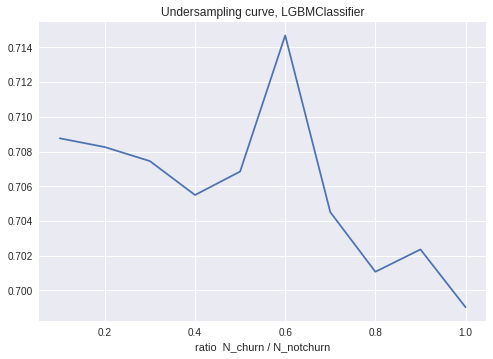

In [51]:
plot_us_res(ratios, lgbmc_us_res, 'LGBMClassifier')

In [52]:
np.mean(lgbmc_us_res, axis=1)

array([0.70876092, 0.70825567, 0.7074469 , 0.70549325, 0.7068453 ,
       0.7146886 , 0.70450775, 0.70107115, 0.70235812, 0.69902936])

In [53]:
# RidgeClassifier

In [54]:
%%time
ridge_us_res = cv_roc_undrsmpl(RidgeClassifier(), X, y, ratios)

CPU times: user 342 ms, sys: 102 ms, total: 444 ms
Wall time: 31.8 s


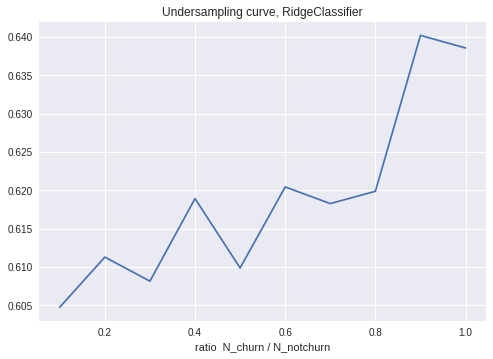

In [55]:
plot_us_res(ratios, ridge_us_res, 'RidgeClassifier')

In [56]:
np.mean(ridge_us_res, axis=1)

array([0.60474047, 0.61127553, 0.60814125, 0.61891056, 0.60985942,
       0.62042919, 0.61825191, 0.61985817, 0.6401901 , 0.6385501 ])

In [57]:
# RandomForestClassifier

In [58]:
%%time
rfrst_us_res = cv_roc_undrsmpl(RandomForestClassifier(), X, y, ratios)

CPU times: user 265 ms, sys: 150 ms, total: 415 ms
Wall time: 1min 16s


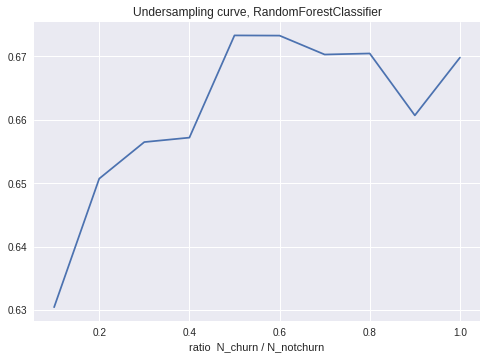

In [59]:
plot_us_res(ratios, rfrst_us_res, 'RandomForestClassifier')

In [60]:
# GradientBoostingClassifier

In [61]:
%%time
gbst_us_res = cv_roc_undrsmpl(GradientBoostingClassifier(), X, y, ratios)

CPU times: user 317 ms, sys: 53.4 ms, total: 371 ms
Wall time: 2min 11s


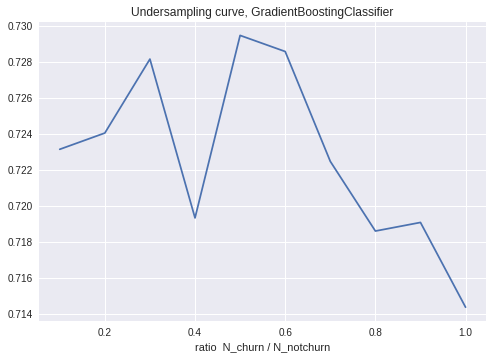

In [62]:
plot_us_res(ratios, gbst_us_res, 'GradientBoostingClassifier')

# Different real features processing

In [63]:
X_train_, X_test_, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=0)

In [64]:
transformer_0 = Transformer(*feat_inds, rfill=0, catstrategy='OneHot')
transformer_mean = Transformer(*feat_inds, rfill='mean', catstrategy='OneHot')

In [65]:
X_r0 = transformer_0.fit_transform(X_)
X_rmean = transformer_mean.fit_transform(X_)

## Filling with zero

In [66]:
def cv_score_rfilling(estimator, X):
    score = cross_val_score(estimator, X, y_, n_jobs=-1, scoring='roc_auc', cv=5)
    print('cv_scores:', score)
    print('average:', score.mean())

In [67]:
# LGBMClassifier

In [68]:
cv_score_rfilling(LGBMClassifier(), X_r0)

cv_scores: [0.69288231 0.71074327 0.72220553 0.71072419 0.70644552]
average: 0.7086001631024051


In [69]:
# RidgeClassifier

In [70]:
cv_score_rfilling(RidgeClassifier(), X_r0)

cv_scores: [0.59025223 0.61662094 0.61687051 0.59717044 0.57554329]
average: 0.5992914829469269


In [71]:
# RandomForestClassifier

In [72]:
cv_score_rfilling(RandomForestClassifier(), X_r0)

cv_scores: [0.6319571  0.62590038 0.64765163 0.62483748 0.6111101 ]
average: 0.6282913364628007


In [73]:
# GradientBoostingClassifier

In [74]:
cv_score_rfilling(GradientBoostingClassifier(), X_r0)

cv_scores: [0.71668808 0.70661787 0.74031115 0.73364655 0.71372837]
average: 0.7221984044343399


## Filling with mean

In [75]:
# LGBMClassifier

cv_score_rfilling(LGBMClassifier(), X_rmean)

cv_scores: [0.69462961 0.70429449 0.73214286 0.71217197 0.7008617 ]
average: 0.7088201255208523


In [76]:
# RidgeClassifier 

cv_score_rfilling(RidgeClassifier(), X_rmean)

cv_scores: [0.59097668 0.62025149 0.62160556 0.59995987 0.57874731]
average: 0.6023081814318358


In [77]:
# RandomForestClassifier

cv_score_rfilling(RandomForestClassifier(), X_rmean)

cv_scores: [0.61345209 0.62121466 0.64539802 0.63041964 0.5959084 ]
average: 0.6212785619265534


In [78]:
# GradientBoostingClassifier

cv_score_rfilling(GradientBoostingClassifier(), X_rmean)

cv_scores: [0.7256857  0.7130824  0.74847531 0.7338298  0.7158022 ]
average: 0.7273750820844558


As a result, for all estimators, except of **RandomForest**, strategy with mean gap filling performs better comparing with zero gap filling

# Different categorical strategies using

In [79]:
feat_inds = [inds_real, inds_bin, inds_cat]

In [80]:
transformer_OneHot = Transformer(*feat_inds, rfill='mean', catstrategy='OneHot')
transformer_Ordinal = Transformer(*feat_inds, rfill='mean', catstrategy='Ordinal')
transformer_Frequency = Transformer(*feat_inds, rfill='mean', catstrategy='Frequency')

In [81]:
X_OneHot = transformer_OneHot.fit_transform(X_)
X_Ordinal = transformer_Ordinal.fit_transform(X_)
X_Frequency = transformer_Frequency.fit_transform(X_)

In [82]:
base_estimators = [LGBMClassifier(), RidgeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]

### OneHot

In [83]:
for estimator in base_estimators:
    cv_score = cross_val_score(estimator, X_OneHot, y_,
                               n_jobs=-1, scoring='roc_auc', cv=5).mean()
    print(f'{estimator} cv_score for OneHot: {cv_score}')

LGBMClassifier() cv_score for OneHot: 0.7088201255208523
RidgeClassifier() cv_score for OneHot: 0.6023081814318358
RandomForestClassifier() cv_score for OneHot: 0.6310589906017636
GradientBoostingClassifier() cv_score for OneHot: 0.727816503008087


### Ordinal

In [84]:
for estimator in base_estimators:
    cv_score = cross_val_score(estimator, X_Ordinal, y_,
                               n_jobs=-1, scoring='roc_auc', cv=5).mean()
    print(f'{estimator} cv_score for Ordinal: {cv_score}')

LGBMClassifier() cv_score for Ordinal: 0.7078727389568308
RidgeClassifier() cv_score for Ordinal: 0.6612468258013842
RandomForestClassifier() cv_score for Ordinal: 0.6554457159583917
GradientBoostingClassifier() cv_score for Ordinal: 0.733130601496009


### Frequency

In [85]:
for estimator in base_estimators:
    cv_score = cross_val_score(estimator, X_Frequency, y_,
                               n_jobs=-1, scoring='roc_auc', cv=5).mean()
    print(f'{estimator} cv_score for Frequency: {cv_score}')

LGBMClassifier() cv_score for Frequency: 0.7177734157680282
RidgeClassifier() cv_score for Frequency: 0.6794697643208261
RandomForestClassifier() cv_score for Frequency: 0.6749727551733743
GradientBoostingClassifier() cv_score for Frequency: 0.7382258297899593


# Feature selection

In [22]:
transformer = Transformer(*feat_inds, rfill='mean', catstrategy='Frequency')

In [87]:
X = transformer.fit_transform(X_)

### L1 based feature selection (with linear SVC)

In [88]:
def get_l1_feat_sel(X, y, C):
    lsvc = LinearSVC(C=C, penalty="l1", dual=False, max_iter=5000, random_state=0)
    model = SelectFromModel(lsvc)
    X_new = model.fit_transform(X, y)
    return X_new

In [89]:
C_arr = np.linspace(0.001, 0.5, 10)
C_arr

array([0.001     , 0.05644444, 0.11188889, 0.16733333, 0.22277778,
       0.27822222, 0.33366667, 0.38911111, 0.44455556, 0.5       ])

In [90]:
base_estimators = [LGBMClassifier(), RidgeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]

#### OneHot

In [ ]:
%%time

cv_OneHot_l1 = []

for estimator in base_estimators:
    cv_scores = []
    for C in C_arr:
        print(f'processing {estimator} with C={C}')
        X_new = get_l1_feat_sel(X_OneHot, y_, C=C)
        cv_scores.append(cross_val_score(estimator, X_new, y_,
                                   n_jobs=-1, scoring='roc_auc', cv=5).mean())
    
    cv_OneHot_l1.append(cv_scores)

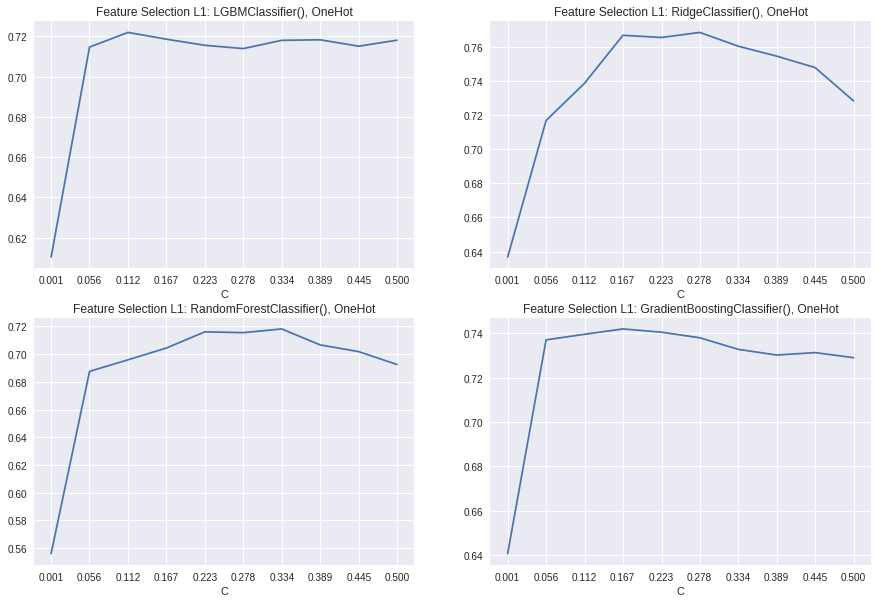

In [91]:
from matplotlib.ticker import FixedLocator

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, estimator in enumerate(base_estimators):
    ax[i//2, i%2].plot(C_arr, cv_OneHot_l1[i])
    ax[i//2, i%2].set_xlabel('C')
    ax[i//2, i%2].set_title(f'Feature Selection L1: {estimator}, OneHot')
    ax[i//2, i%2].xaxis.set_major_locator(FixedLocator(np.round(C_arr, 3)))

In [92]:
# results
print('       ', *np.round(C_arr, 2), sep='  ')
np.round(cv_OneHot_l1, 3)

         0.0  0.06  0.11  0.17  0.22  0.28  0.33  0.39  0.44  0.5


array([[0.61 , 0.715, 0.722, 0.719, 0.716, 0.714, 0.718, 0.718, 0.715,
        0.718],
       [0.637, 0.717, 0.739, 0.767, 0.765, 0.768, 0.76 , 0.754, 0.748,
        0.728],
       [0.556, 0.688, 0.696, 0.704, 0.716, 0.715, 0.718, 0.707, 0.702,
        0.692],
       [0.641, 0.737, 0.739, 0.742, 0.74 , 0.738, 0.733, 0.73 , 0.731,
        0.729]])

### Ordinal

In [ ]:
%%time

cv_Ordinal_l1 = []

for estimator in base_estimators:
    cv_scores = []
    for C in C_arr:
        print(f'processing {estimator} with C={C}')
        X_new = get_l1_feat_sel(X_Ordinal, y_, C=C)
        cv_scores.append(cross_val_score(estimator, X_new, y_,
                                   n_jobs=-1, scoring='roc_auc', cv=5).mean())
    
    cv_Ordinal_l1.append(cv_scores)

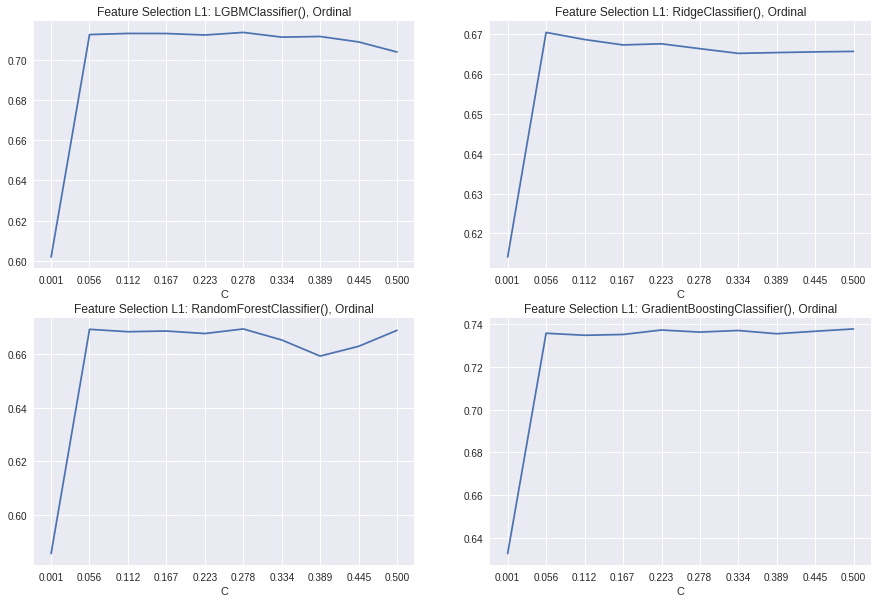

In [93]:
from matplotlib.ticker import FixedLocator

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, estimator in enumerate(base_estimators):
    ax[i//2, i%2].plot(C_arr, cv_Ordinal_l1[i])
    ax[i//2, i%2].set_xlabel('C')
    ax[i//2, i%2].set_title(f'Feature Selection L1: {estimator}, Ordinal')
    ax[i//2, i%2].xaxis.set_major_locator(FixedLocator(np.round(C_arr, 3)))

In [94]:
# results
print('       ', *np.round(C_arr, 2), sep='  ')
np.round(cv_Ordinal_l1, 3)

         0.0  0.06  0.11  0.17  0.22  0.28  0.33  0.39  0.44  0.5


array([[0.602, 0.713, 0.713, 0.713, 0.712, 0.714, 0.711, 0.712, 0.709,
        0.704],
       [0.614, 0.67 , 0.669, 0.667, 0.668, 0.666, 0.665, 0.665, 0.666,
        0.666],
       [0.586, 0.669, 0.668, 0.669, 0.668, 0.67 , 0.665, 0.659, 0.663,
        0.669],
       [0.633, 0.736, 0.735, 0.735, 0.737, 0.736, 0.737, 0.735, 0.737,
        0.738]])

### Frequency

In [ ]:
%%time

cv_Frequency_l1 = []

for estimator in base_estimators:
    cv_scores = []
    for C in C_arr:
        print(f'processing {estimator} with C={C}')
        X_new = get_l1_feat_sel(X_Frequency, y_, C=C)
        cv_scores.append(cross_val_score(estimator, X_new, y_,
                                   n_jobs=-1, scoring='roc_auc', cv=5).mean())
    
    cv_Frequency_l1.append(cv_scores)

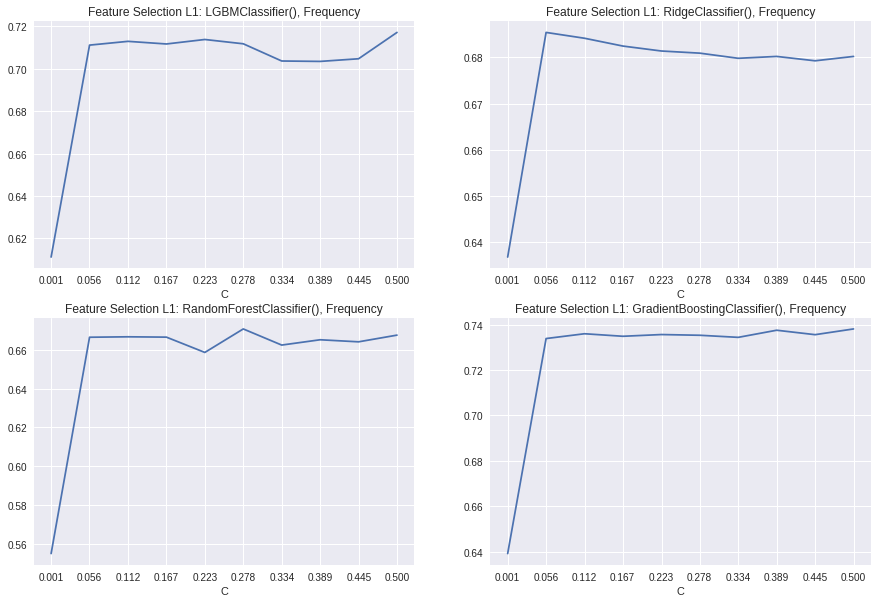

In [95]:
from matplotlib.ticker import FixedLocator

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, estimator in enumerate(base_estimators):
    ax[i//2, i%2].plot(C_arr, cv_Frequency_l1[i])
    ax[i//2, i%2].set_xlabel('C')
    ax[i//2, i%2].set_title(f'Feature Selection L1: {estimator}, Frequency')
    ax[i//2, i%2].xaxis.set_major_locator(FixedLocator(np.round(C_arr, 3)))

In [97]:
# results
print('       ', *np.round(C_arr, 2), sep='  ')
np.round(cv_Frequency_l1, 3)

         0.0  0.06  0.11  0.17  0.22  0.28  0.33  0.39  0.44  0.5


array([[0.611, 0.711, 0.713, 0.712, 0.714, 0.712, 0.704, 0.703, 0.705,
        0.717],
       [0.637, 0.685, 0.684, 0.682, 0.681, 0.681, 0.68 , 0.68 , 0.679,
        0.68 ],
       [0.555, 0.666, 0.667, 0.666, 0.659, 0.671, 0.662, 0.665, 0.664,
        0.667],
       [0.639, 0.734, 0.736, 0.735, 0.736, 0.735, 0.734, 0.737, 0.736,
        0.738]])

### SelectKBest feature selection (with f_classif)

In [98]:
# we will take 20%, 40%, 60%, 80% and 100% amount from the original features

In [99]:
perc = [.002, .004, .01, .05, .1, .2, .4, .6]

### OneHot

In [100]:
# we will take 0.2%, 0.4%, 1%, 5%, 10%, 20%, 40%, 60%  amount from the original features

In [ ]:
%%time

cv_OneHot_fclsf = []
k_arr = (np.array(perc) * X_OneHot.shape[1]).astype(int)

for estimator in base_estimators:
    cv_scores = []
    for k in k_arr:
        print(f'processing {estimator} with k={k}')
        X_new = SelectKBest(f_classif, k=k).fit_transform(X_OneHot, y_)
        cv_scores.append(cross_val_score(estimator, X_new, y_,
                                        n_jobs=-1, scoring='roc_auc', cv=5).mean())
    cv_OneHot_fclsf.append(cv_scores)

In [101]:
(np.array(perc) * X_OneHot.shape[1]).astype(int)

array([   70,   141,   353,  1767,  3534,  7069, 14138, 21207])

In [102]:
np.round(cv_OneHot_fclsf, 5)

array([[0.6649 , 0.72461, 0.72156, 0.73552, 0.72562, 0.71581, 0.71314,
        0.71314],
       [0.69112, 0.71738, 0.7203 , 0.73718, 0.66331, 0.63189, 0.62471,
        0.62809],
       [0.64066, 0.70187, 0.69909, 0.70106, 0.69154, 0.66773, 0.64636,
        0.65168],
       [0.69556, 0.7508 , 0.74287, 0.7342 , 0.72818, 0.72695, 0.72827,
        0.72717]])

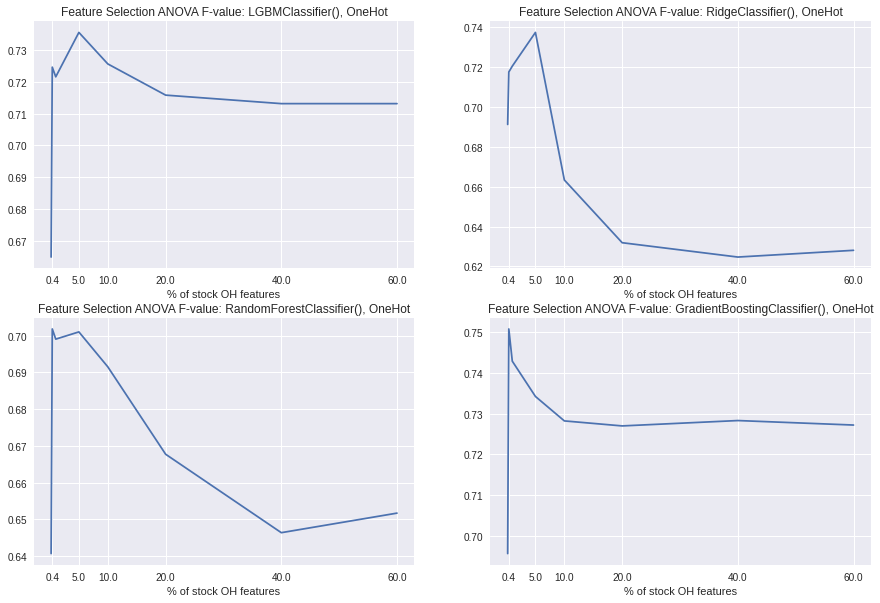

In [103]:
from matplotlib.ticker import FixedLocator

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, estimator in enumerate(base_estimators):
    ax[i//2, i%2].plot(np.array(perc)*100, cv_OneHot_fclsf[i])
    ax[i//2, i%2].set_xlabel('% of stock OH features')
    ax[i//2, i%2].set_title(f'Feature Selection ANOVA F-value: {estimator}, OneHot')
    #ax[i//2, i%2].set_ylim(ymin=0.67)
    ax[i//2, i%2].xaxis.set_major_locator(FixedLocator([.4, 5, 10, 20, 40, 60]))

### Ordinal

In [104]:
X_.shape

(14638, 230)

In [ ]:
%%time

cv_Ordinal_fclsf = []
k_arr = (np.array(perc) * X_Ordinal.shape[1]).astype(int)

for estimator in base_estimators:
    cv_scores = []
    for k in k_arr:
        print(f'processing {estimator} with k={k}')
        X_new = SelectKBest(f_classif, k=k).fit_transform(X_Ordinal, y_)
        cv_scores.append(cross_val_score(estimator, X_new, y_,
                                        n_jobs=-1, scoring='roc_auc', cv=5).mean())
    cv_Ordinal_fclsf.append(cv_scores)

In [105]:
np.round(cv_Ordinal_fclsf, 5)

array([[    nan,     nan, 0.59945, 0.64765, 0.72112, 0.71506, 0.71318,
        0.70735],
       [    nan,     nan, 0.61272, 0.6592 , 0.66735, 0.67366, 0.67251,
        0.66766],
       [    nan,     nan, 0.58878, 0.59813, 0.69258, 0.68528, 0.6752 ,
        0.66632],
       [    nan,     nan, 0.61056, 0.66999, 0.7394 , 0.73977, 0.73844,
        0.73723]])

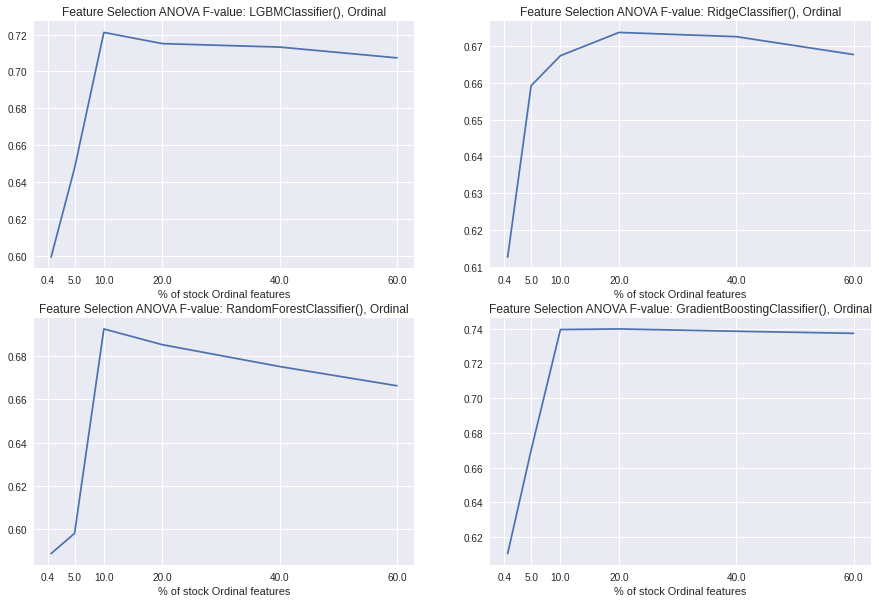

In [106]:
from matplotlib.ticker import FixedLocator

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, estimator in enumerate(base_estimators):
    ax[i//2, i%2].plot(np.array(perc)*100, cv_Ordinal_fclsf[i])
    ax[i//2, i%2].set_xlabel('% of stock Ordinal features')
    ax[i//2, i%2].set_title(f'Feature Selection ANOVA F-value: {estimator}, Ordinal')
    #ax[i//2, i%2].set_ylim(ymin=0.71)
    ax[i//2, i%2].xaxis.set_major_locator(FixedLocator([.4, 5, 10, 20, 40, 60]))

### Frequency

In [ ]:
%%time

cv_Frequency_fclsf = []
k_arr = (np.array(perc) * X_Frequency.shape[1]).astype(int)

for estimator in base_estimators:
    cv_scores = []
    for k in k_arr:
        print(f'processing {estimator} with k={k}')
        X_new = SelectKBest(f_classif, k=k).fit_transform(X_Frequency, y_)
        cv_scores.append(cross_val_score(estimator, X_new, y_,
                                        n_jobs=-1, scoring='roc_auc', cv=5).mean())
    cv_Frequency_fclsf.append(cv_scores)

In [107]:
np.round(cv_Frequency_fclsf, 5)

array([[    nan,     nan, 0.54857, 0.64055, 0.65879, 0.72493, 0.72527,
        0.7211 ],
       [    nan,     nan, 0.57383, 0.65928, 0.66969, 0.68819, 0.68497,
        0.68478],
       [    nan,     nan, 0.55019, 0.59484, 0.62969, 0.69057, 0.68584,
        0.67939],
       [    nan,     nan, 0.54974, 0.66695, 0.67874, 0.74852, 0.74077,
        0.74157]])

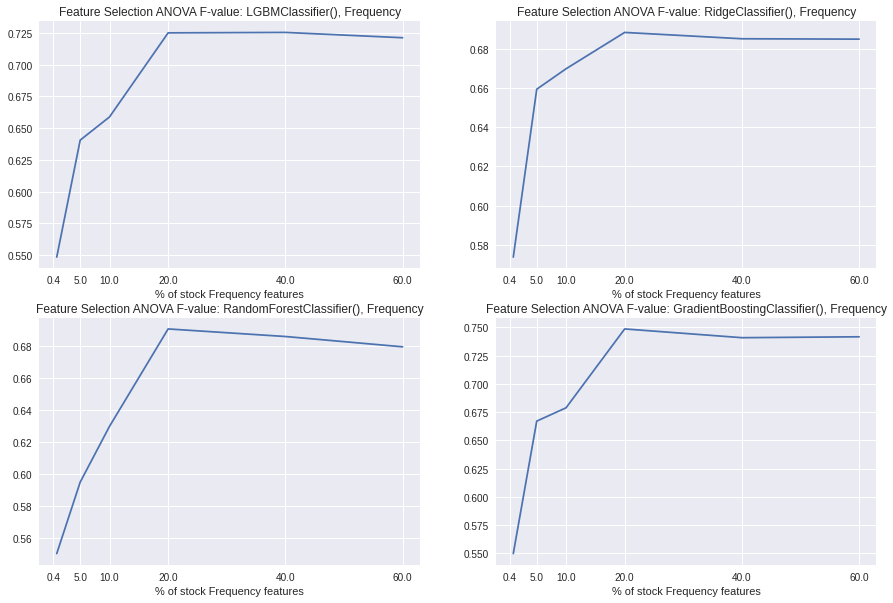

In [108]:
from matplotlib.ticker import FixedLocator

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, estimator in enumerate(base_estimators):
    ax[i//2, i%2].plot(np.array(perc)*100, cv_Frequency_fclsf[i])
    ax[i//2, i%2].set_xlabel('% of stock Frequency features')
    ax[i//2, i%2].set_title(f'Feature Selection ANOVA F-value: {estimator}, Frequency')
    #ax[i//2, i%2].set_ylim(ymin=0.71)
    ax[i//2, i%2].xaxis.set_major_locator(FixedLocator([.4, 5, 10, 20, 40, 60]))

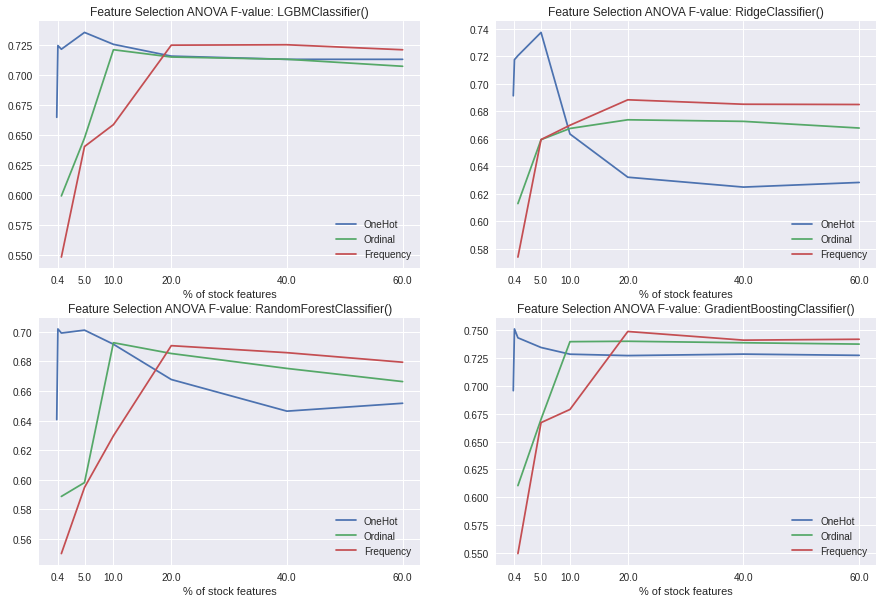

In [109]:
# Comparison
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, estimator in enumerate(base_estimators):
    ax[i//2, i%2].plot(np.array(perc)*100, cv_OneHot_fclsf[i], label='OneHot')
    ax[i//2, i%2].plot(np.array(perc)*100, cv_Ordinal_fclsf[i], label='Ordinal')
    ax[i//2, i%2].plot(np.array(perc)*100, cv_Frequency_fclsf[i], label='Frequency')
    
    ax[i//2, i%2].set_xlabel('% of stock features')
    ax[i//2, i%2].set_title(f'Feature Selection ANOVA F-value: {estimator}')
    #ax[i//2, i%2].set_ylim(ymin=0.71)
    ax[i//2, i%2].legend(loc='lower right')
    ax[i//2, i%2].xaxis.set_major_locator(FixedLocator([.4, 5, 10, 20, 40, 60]))

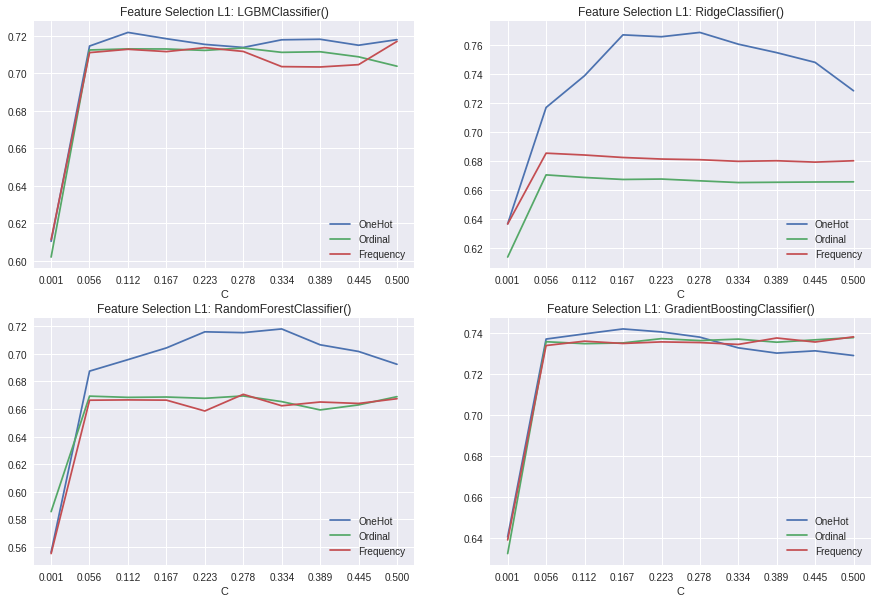

In [110]:
# Comparison
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, estimator in enumerate(base_estimators):
    ax[i//2, i%2].plot(C_arr, cv_OneHot_l1[i], label='OneHot')
    ax[i//2, i%2].plot(C_arr, cv_Ordinal_l1[i], label='Ordinal')
    ax[i//2, i%2].plot(C_arr, cv_Frequency_l1[i], label='Frequency')
    
    ax[i//2, i%2].set_xlabel('C')
    ax[i//2, i%2].set_title(f'Feature Selection L1: {estimator}')
    #ax[i//2, i%2].set_ylim(ymin=0.71)
    ax[i//2, i%2].legend(loc='lower right')
    ax[i//2, i%2].xaxis.set_major_locator(FixedLocator(np.round(C_arr, 3)))

base_algo + weightsvar/undersampling + strategy + featureselection

In [84]:
X_

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
11031,NaN,NaN,NaN,NaN,NaN,1239.0,7.0,NaN,NaN,NaN,...,oslk,bSgltRa,LM8l689qOp,NaN,NaN,wX53,RAYp,F2FyR07IdsN7I,NaN,NaN
4308,NaN,NaN,NaN,NaN,NaN,1470.0,7.0,NaN,NaN,NaN,...,oslk,PgO2Oqu,LM8l689qOp,NaN,kG3k,WqMG,RAYp,F2FyR07IdsN7I,am7c,NaN
1457,NaN,NaN,NaN,NaN,NaN,3395.0,21.0,NaN,NaN,NaN,...,oslk,tByjPJU,LM8l689qOp,NaN,NaN,me1d,RAYp,F2FyR07IdsN7I,NaN,NaN
15925,NaN,NaN,NaN,NaN,NaN,3080.0,7.0,NaN,NaN,NaN,...,oslk,nTRqEo9,LM8l689qOp,NaN,kG3k,Aoh3,RAYp,F2FyR07IdsN7I,mj86,NaN
16893,NaN,NaN,NaN,NaN,NaN,1253.0,7.0,NaN,NaN,NaN,...,d0EEeJi,reJWvXc,jySVZNlOJy,NaN,ELof,Xa3G,nIGXDli,F2FyR07IdsN7I,am7c,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9225,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,oslk,lcWqFbB,LM8l689qOp,4n2X,NaN,Qu4f,RAYp,F2FyR07IdsN7I,NaN,NaN
13123,NaN,NaN,NaN,NaN,NaN,546.0,7.0,NaN,NaN,NaN,...,d0EEeJi,u1m99Dn,LM8l689qOp,NaN,NaN,szEZ,nIGXDli,F2FyR07IdsN7I,NaN,NaN
9845,NaN,NaN,NaN,NaN,NaN,245.0,14.0,NaN,NaN,NaN,...,zCkv,hHJsvbM,NaN,NaN,NaN,PM2D,6fzt,F2FcTt7IdMT_v,NaN,NaN
10799,NaN,NaN,NaN,NaN,NaN,1057.0,14.0,NaN,NaN,NaN,...,d0EEeJi,gfBRUH6,LM8l689qOp,NaN,ELof,453m,nIGXDli,F2FyR07IdsN7I,am7c,NaN


# GradientBoostingClassifier + Undersampling + OneHot + FeatureSelection 

In [32]:
np.random.seed(0)

In [17]:
gbc_estimator = make_pipeline(Transformer(*feat_inds, rfill='mean', catstrategy='OneHot'),
                              RandomUnderSampler(random_state=0),
                              VarianceThreshold(),
                              SelectKBest(f_classif),
                              GradientBoostingClassifier(random_state=0))

In [18]:
# Оптимальная модель

gbc_estimator.set_params(**{'gradientboostingclassifier__criterion': 'friedman_mse',
                            'gradientboostingclassifier__learning_rate': 0.1,
                            'gradientboostingclassifier__loss': 'exponential',
                            'gradientboostingclassifier__max_depth': 4,
                            'gradientboostingclassifier__max_features': 'sqrt',
                            'gradientboostingclassifier__n_estimators': 150,
                            'gradientboostingclassifier__subsample': 1.0,
                            'selectkbest__k': 160})

Pipeline(steps=[('transformer',
                 Transformer(inds_bin=[False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False, ...],
                             inds_cat=[False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False,...
                                        True, False, True, True, True, True,
                                        True, True, True, True, True, True, ...],
                             rfill='mean')),
                ('randomundersampler', RandomUnderSampler(random_state=0)),
                ('variancethreshold', 

In [35]:
cross_val_score(gbc_estimator, X_, y_, 
                scoring='roc_auc', cv=5, n_jobs=-1).mean()

0.7427656672979314

In [36]:
gbc_estimator.fit(X_, y_)

Pipeline(steps=[('transformer',
                 Transformer(inds_bin=[False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False, ...],
                             inds_cat=[False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False,...
                                        True, True, True, True, True, True, ...],
                             rfill='mean')),
                ('randomundersampler',
                 RandomUnderSampler(random_state=0, sampling_strategy=0.09)),
                ('variancethreshold', VarianceThreshold()),
              

In [37]:
roc_auc_score(y_hold, gbc_estimator.predict_proba(X_hold)[:, 1])

0.7140583380958339

In [19]:
parameters_grid = {
    'selectkbest__k': [90, 100, 120, 140, 160],
    'gradientboostingclassifier__max_depth': [2, 3, 4],
    'gradientboostingclassifier__loss': ['deviance', 'exponential'],
    'gradientboostingclassifier__n_estimators': [150],    
    'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.5],
    'gradientboostingclassifier__max_features':["log2","sqrt"],
    'gradientboostingclassifier__criterion': ["friedman_mse",  "squared_error"],
    'gradientboostingclassifier__subsample':[0.5, 0.8, 1.0],
    #'randomundersampler__sampling_strategy': [.1, .2, .3, 0.5],
    #'gradientboostingclassifier__min_samples_split': np.linspace(0.1, 0.5, 12),
    #'gradientboostingclassifier__min_samples_leaf': np.linspace(0.1, 0.5, 12),
}

In [20]:
gbc_grid = GridSearchCV(gbc_estimator, parameters_grid,
                        scoring = 'roc_auc', cv = 5, n_jobs=-1)

In [21]:
%%time
gbc_grid.fit(X_, y_)

C:\Users\dpane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2700 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2700 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dpane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dpane\anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\dpane\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 586, in fit
    n_stages = self._fit_stages(
  File "C:\Users\dpane\anaconda3\l

Wall time: 10min 6s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        Transformer(inds_bin=[False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
              

In [22]:
gbc_grid.best_score_

0.7287003444236916

In [23]:
gbc_grid.best_params_

{'gradientboostingclassifier__criterion': 'friedman_mse',
 'gradientboostingclassifier__learning_rate': 0.1,
 'gradientboostingclassifier__loss': 'deviance',
 'gradientboostingclassifier__max_depth': 2,
 'gradientboostingclassifier__max_features': 'sqrt',
 'gradientboostingclassifier__n_estimators': 150,
 'gradientboostingclassifier__subsample': 0.8,
 'selectkbest__k': 90}

In [28]:
gbc_grid.best_estimator_

Pipeline(steps=[('transformer',
                 Transformer(inds_bin=[False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False, ...],
                             inds_cat=[False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False,...
                                        True, False, True, True, True, True,
                                        True, True, True, True, True, True, ...],
                             rfill='mean')),
                ('randomundersampler', RandomUnderSampler(random_state=0)),
                ('variancethreshold', 

In [31]:
gbc_grid.best_estimator_.steps[4][1].feature_importances_

array([9.29008838e-03, 1.56208737e-02, 6.28761544e-02, 1.02022746e-02,
       1.03218336e-02, 7.62060768e-03, 2.66484199e-02, 4.10674943e-02,
       3.20035235e-02, 6.23234705e-03, 6.10245727e-02, 2.30002349e-01,
       1.49620140e-02, 1.11170876e-02, 7.48447317e-03, 1.20037537e-01,
       6.20834883e-03, 8.66771420e-03, 7.19547585e-03, 6.62035993e-03,
       5.81301218e-03, 1.08161379e-02, 7.69977071e-03, 3.41313004e-04,
       1.50648615e-03, 1.44555999e-03, 0.00000000e+00, 7.54420237e-03,
       4.55047930e-03, 5.33470431e-03, 4.97244357e-03, 0.00000000e+00,
       4.21828035e-03, 1.03106236e-03, 6.79085579e-03, 2.67737071e-03,
       5.16899845e-03, 8.40236453e-03, 2.33862418e-03, 4.21012264e-03,
       6.48625838e-03, 3.75434773e-03, 1.79919428e-03, 6.16400240e-03,
       5.81731688e-04, 1.11701760e-03, 5.85151531e-03, 2.27281982e-03,
       3.55713577e-02, 6.74846299e-04, 4.80464118e-04, 8.76106006e-04,
       1.92516014e-04, 4.22542403e-03, 0.00000000e+00, 7.62096761e-03,
      

In [32]:
gbc_grid.best_score_

0.7287003444236916

In [33]:
gbc_grid.best_params_

{'gradientboostingclassifier__criterion': 'friedman_mse',
 'gradientboostingclassifier__learning_rate': 0.1,
 'gradientboostingclassifier__loss': 'deviance',
 'gradientboostingclassifier__max_depth': 2,
 'gradientboostingclassifier__max_features': 'sqrt',
 'gradientboostingclassifier__n_estimators': 150,
 'gradientboostingclassifier__subsample': 0.8,
 'selectkbest__k': 90}

******

In [35]:
estimator = gbc_grid.best_estimator_

In [36]:
X_curtrain, X_curtest, y_curtrain, y_curtest = train_test_split(X_, y_, test_size=.2, shuffle=True, random_state=0)

In [48]:
estimator.fit(X_curtrain, y_curtrain)

Pipeline(steps=[('transformer',
                 Transformer(inds_bin=[False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False, ...],
                             inds_cat=[False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False,...
                                        True, False, True, True, True, True,
                                        True, True, True, True, True, True, ...],
                             rfill='mean')),
                ('randomundersampler', RandomUnderSampler(random_state=0)),
                ('variancethreshold', 

In [49]:
roc_auc_score(y_hold, estimator.predict_proba(X_hold)[:, 1])

0.7024198011811001

# GradientBoostingClassifier + Oversampling + OneHot + FeatureSelection 

In [22]:
gbc_estimator_os = make_pipeline(Transformer(*feat_inds, catstrategy='OneHot'),
                                 RandomOverSampler(random_state=0),
                                 VarianceThreshold(),
                                 SelectKBest(f_classif),
                                 GradientBoostingClassifier(random_state=0))

In [23]:
# Оптимальная модель

gbc_estimator_os.set_params(**{'randomoversampler__sampling_strategy': .9,
                               'selectkbest__k': 100,
                               'transformer__rfill': 'mean',
                               'variancethreshold__threshold': .0001,
                               'gradientboostingclassifier__loss': 'deviance', # 'exponential', # 
                               'gradientboostingclassifier__n_estimators': 150,
                               'gradientboostingclassifier__max_features':"sqrt",
                               })

Pipeline(steps=[('transformer',
                 Transformer(inds_bin=[False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False, ...],
                             inds_cat=[False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False,...
                                        True, False, True, True, True, True,
                                        True, True, True, True, True, True, ...],
                             rfill='mean')),
                ('randomoversampler',
                 RandomOverSampler(random_state=0, sampling_strategy=0.9)),


In [30]:
cross_val_score(gbc_estimator_os, X_, y_,
                scoring = 'roc_auc', cv = 5, n_jobs=-1).mean()

0.732426034216026

**Поиск производился с помощью GridSearch**

In [203]:
parameters_grid_os = {
    'randomoversampler__sampling_strategy': [.9],
    'transformer__rfill': ['mean'],
    'selectkbest__k': [80, 100, 140, 150, 160, 200],
    'variancethreshold__threshold': [.0001, .0002, .0003, .0007, .001, .002],
    'gradientboostingclassifier__loss': ['deviance', 'exponential'],
    'gradientboostingclassifier__n_estimators': [150],    
    'gradientboostingclassifier__max_features':["sqrt"],
}

In [204]:
gbc_grid_os = GridSearchCV(gbc_estimator_os, parameters_grid_os,
                           scoring = 'roc_auc', cv = 5, n_jobs=-1)

In [205]:
%%time
gbc_grid_os.fit(X_, y_)

Wall time: 2min 27s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        Transformer(inds_bin=[False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
                                                              False, False,
              

In [206]:
gbc_grid_os.best_score_

0.732426034216026

In [207]:
gbc_grid_os.best_params_

{'gradientboostingclassifier__loss': 'deviance',
 'gradientboostingclassifier__max_features': 'sqrt',
 'gradientboostingclassifier__n_estimators': 150,
 'randomoversampler__sampling_strategy': 0.9,
 'selectkbest__k': 100,
 'transformer__rfill': 'mean',
 'variancethreshold__threshold': 0.0001}

In [92]:
estimator = gbc_grid_os.best_estimator_
estimator.fit(X_, y_)

Pipeline(steps=[('transformer',
                 Transformer(inds_bin=[False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False, False, ...],
                             inds_cat=[False, False, False, False, False, False,
                                       False, False, False, False, False, False,
                                       False, False, False, False, False,...
                                        True, True, True, True, True, True, ...],
                             rfill='mean')),
                ('variancethreshold', VarianceThreshold(threshold=0.001)),
                ('randomoversampler',
                 RandomOverSampler(random_state=0, sampling_strategy=0.085)),


In [208]:
roc_auc_score(y_hold, gbc_grid_os.best_estimator_.predict_proba(X_hold)[:, 1])

0.726283028927823

# Storing important datum

In [ ]:
%store

In [ ]:
# Datum
%store X y X_hold y_hold data y_data

In [ ]:
# Learning curves
%store train_sizes train_scores_lgbmc train_scores_ridge train_scores_rfrst train_scores_gbst

In [ ]:
# Weight variation
%store churn_weights lgbmc_wght_res ridge_wght_res rfrst_wght_res gbst_wght_res

# Submitting

In [61]:
# Cчитаем данные из файла
raw_test_data = pd.read_csv('orange_small_churn_test_data.csv')

In [62]:
test_data = raw_test_data.drop(columns=['ID'])

In [63]:
test_data

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,NaN,...,zCkv,APgdzOv,jySVZNlOJy,NaN,ELof,xb3V,6fzt,Zy3gnGM,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,896.0,14.0,NaN,NaN,NaN,...,oslk,IIvC99a,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,oslk,6YSocsg,LM8l689qOp,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,2296.0,7.0,NaN,NaN,NaN,...,oslk,5nQ7A2G,jySVZNlOJy,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,am7c,NaN
4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,...,oslk,MI8s5nE,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,NaN,NaN,NaN,NaN,714.0,7.0,NaN,NaN,NaN,...,zCkv,P6pu4Vl,LM8l689qOp,NaN,ELof,xb3V,ZI9m,R4y5gQQWY8OodqDV,am7c,NaN
9996,NaN,NaN,NaN,NaN,NaN,812.0,7.0,NaN,NaN,NaN,...,oslk,sXbT3Cb,LM8l689qOp,NaN,ELof,WqMG,RAYp,55YFVY9,mj86,NaN
9997,NaN,NaN,NaN,NaN,NaN,819.0,7.0,NaN,NaN,NaN,...,oslk,05jAV0N,M_8D,NaN,ELof,TNEC,RAYp,55YFVY9,am7c,NaN
9998,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,...,oslk,RDY7kpB,LM8l689qOp,NaN,NaN,uWr3,RAYp,55YFVY9,NaN,NaN


In [215]:
estimator = gbc_grid_os.best_estimator_

In [216]:
probs = estimator.predict_proba(test_data)[:, 1]

In [217]:
tosubmit = pd.DataFrame({'Id': list(range(len(probs))), 'result': probs})
tosubmit

,Id,result
0,0,0.584702
1,1,0.562958
2,2,0.230581
3,3,0.459699
4,4,0.203588
...,...,...
9995,9995,0.316390
9996,9996,0.348876
9997,9997,0.225824
9998,9998,0.341784


In [218]:
tosubmit.to_csv('submission_grad5.csv', index=False)

**Final evaluation** on kaggle gives ROC AUC score `0.707`. It is better than the other `35%` of participants